## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import math
import os
import warnings
from random import randint
%matplotlib inline

## Camera calibration using chessboard images

First step is to take 20 to 30 pictures of a chessboard with the camera you will be using on the self driving car. I have placed these images inside `camera_calibration_images`. Then determine

- nx: Number of corners in any given row
- ny: Number of corners in any given column

<b>corners:</b> Points where two black and two white squares intersect.

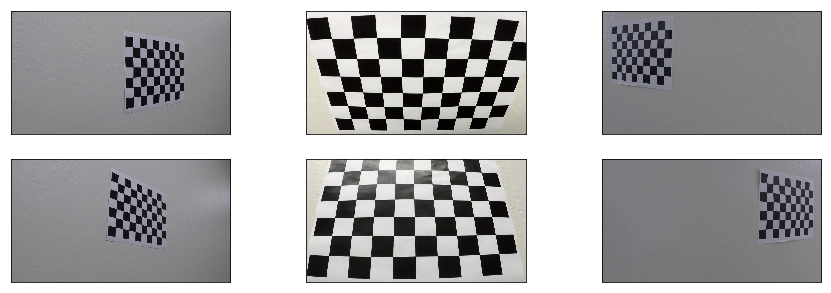

In [2]:
# Make a list of paths to calibration images
cal_img_paths = glob.glob(os.path.join("camera_calibration_images" , "calibration*.jpg"))

# Read and Display samples
plt.figure(figsize=(15, 5))  # width and heights in inches
for i in range( min(6,len(cal_img_paths) )):
    image = mpimg.imread(cal_img_paths[i])
    plt.subplot(2,3,i+1), plt.xticks([]), plt.yticks([])
    plt.imshow(image)

From the above images you can see that my chessboard has nx=9 , ny=6. Now let's define the object points to determine the [camera calibration parameters](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html).

In [3]:
# Arrays to store object points and image points for each calibration image.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(ny,nx,0) in a column
nx, ny = 9, 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for i in range(len(cal_img_paths)):
    image = mpimg.imread(cal_img_paths[i])
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera Calibration Parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("\n Matrix Coefficients \n", mtx)
print("\n Distortion Coefficients [k1 k2 p1 p2 k3] \n",dist)


 Matrix Coefficients 
 [[  1.15777829e+03   0.00000000e+00   6.67113866e+02]
 [  0.00000000e+00   1.15282230e+03   3.86124658e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

 Distortion Coefficients [k1 k2 p1 p2 k3] 
 [[-0.24688572 -0.02372825 -0.00109832  0.00035104 -0.00260431]]


## Distortion Correction

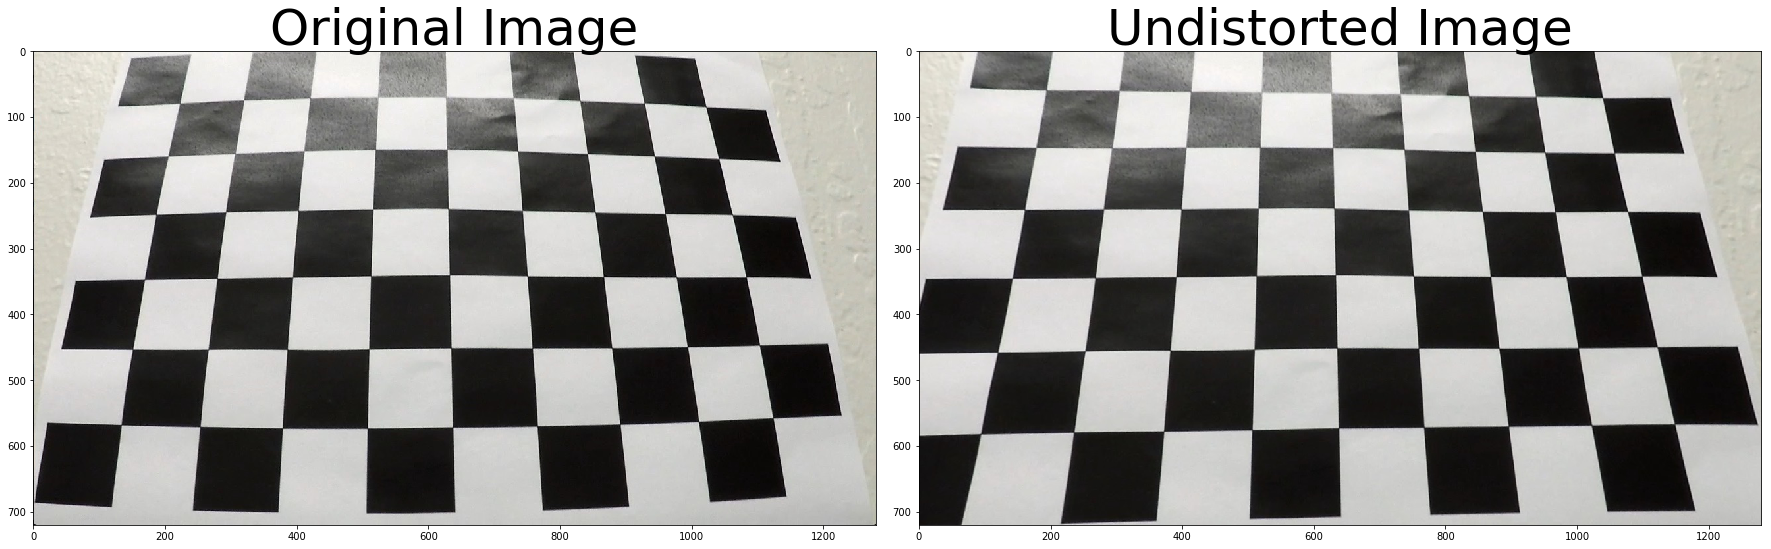

In [4]:
# Undistort random calibration image
indx   = randint(0,len(cal_img_paths))
image  = mpimg.imread(cal_img_paths[indx])
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Read in Test Images
In `Udacity_dataset` there is a `test_images` folder which contains 2 straight line images for aligning perspective transform and 6 other test images. 


 Location  : Udacity_dataset/test_images/straight_lines2.jpg 
 Dimensions: (720, 1280, 3)


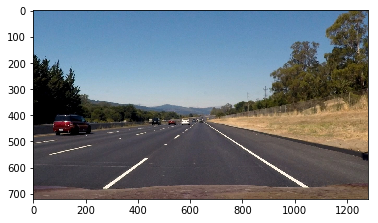

In [5]:
straight_line_test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","straight*.jpg"))
test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","test*.jpg"))
                              
# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list

# Display
print('\n Location  :', straight_line_test_images_paths[0], '\n Dimensions:', image.shape)
plt.imshow(image)

## Apply Perspective Transformation
Next, you want to identify four source points for your perspective transform. The easiest way to do this is to investigate an image where the lane lines are straight. Try experimenting with different src points.

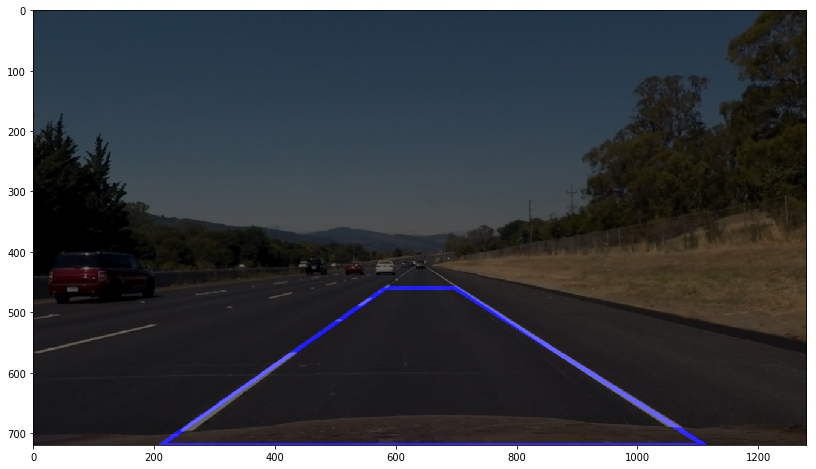

In [15]:
def draw_roi_box(img, vertices, color=[0, 0, 255], thickness=5):
    """
    Draw a contour around region of interest on img (binary or color)
    Vertices must be 2D array of coordinate pairs [[(x1,y1),...,(x4,y4)]]
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw the lines
    for vertex in vertices:   # used 'for' to get rid of 2D array
        cv2.line(img_to_draw, tuple(vertex[0]), tuple(vertex[1]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[1]), tuple(vertex[2]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[2]), tuple(vertex[3]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[3]), tuple(vertex[0]), color, thickness)
           
    # Add detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 0.4, 0) 
    return output_img


# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list
image = cv2.undistort(image, mtx, dist, None, mtx)

# Obtain source points
height, width = image.shape[:2]
offset  = 20   # camera offset from center of car
bottom_left   =( width/2 -450 +offset   , height) 
upper_left    =( width/2 -58            , height/2+100)
upper_right   =( width/2 +58            , height/2+100)
bottom_right  =( width/2 +450 +offset   , height)
vertices = np.array([[bottom_left,upper_left,upper_right,bottom_right]], dtype=np.int32)

# Display
plt.figure(figsize=(15, 8))  # width and heights in inches
plt.imshow(draw_roi_box(image, vertices))

Now that we have acquired the source points let's apply the perspective transform

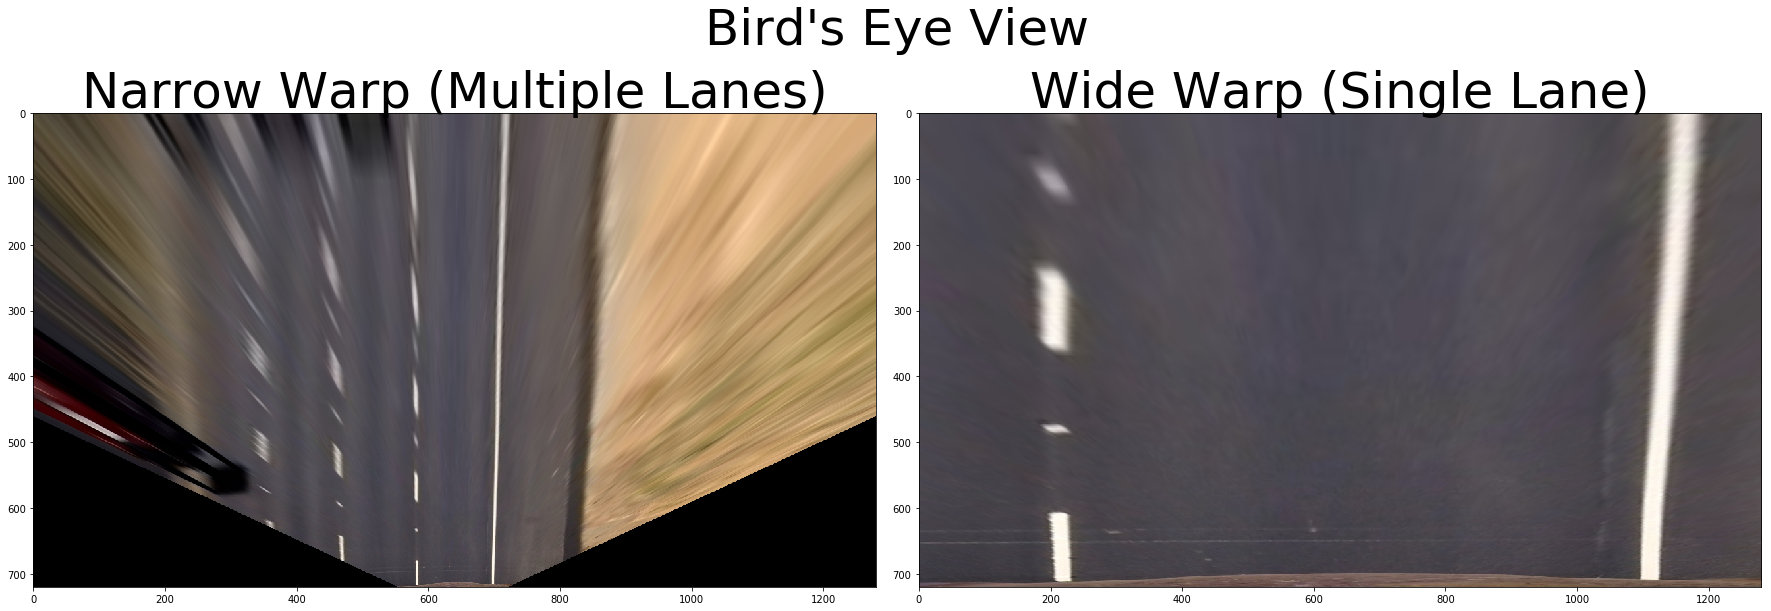

In [16]:
# Source Points
src = np.float32(vertices[0]) # with [0] we reduce one dimension

# Destination Points   
dst_wide = np.float32([bottom_left,
                   [bottom_left[0], 0],
                   [bottom_right[0],0],
                   bottom_right])
dst_narrow = np.float32([[upper_left[0],height],
                         upper_left,
                         upper_right,
                         [upper_right[0],height]])

# Perspective Transform Matrix
M_wide   = cv2.getPerspectiveTransform(src, dst_wide)
M_narrow = cv2.getPerspectiveTransform(src, dst_narrow)

# Warped Images
warped_wide   = cv2.warpPerspective(image, M_wide, (width,height))
warped_narrow = cv2.warpPerspective(image, M_narrow, (width,height))

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
plt.suptitle("Bird's Eye View", fontsize=50)
ax1.set_title('Narrow Warp (Multiple Lanes)', fontsize=50)
ax1.imshow(warped_narrow)
ax2.set_title('Wide Warp (Single Lane)', fontsize=50)
ax2.imshow(warped_wide)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert to a Thresholded Binary Image
This section is based on this [Repo](https://github.com/laygond/EdgeDetection-and-ColorSpaces.git) which explores color spaces and edge detection techniques.

#### Helper Functions

In [29]:
def applyThresh(image, thresh=(0,255)):
    """
    Apply threshold to binary image. Setting to '1' pixels> minThresh & pixels <= maxThresh.
    """
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary

def S_channel(image):
    """
    Returns the Saturation channel from an RGB image.
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return S
    
def sobel_X(image):
    """
    Applies Sobel in the x direction to an RGB image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3))
    sobelx     = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    return sobelx

def binary_pipeline(image):
    """
    Combination of color and gradient thresholds for lane detection. 
    Input image must be RGB
    """
    sobelx    = sobel_X(image)
    s_channel = S_channel(image)
    
    bin_sobelx    = applyThresh(sobelx, thresh=(20,100))
    bin_s_channel = applyThresh(s_channel, thresh=(90,255))
    
    return bin_sobelx | bin_s_channel

#### Binary Pipeline

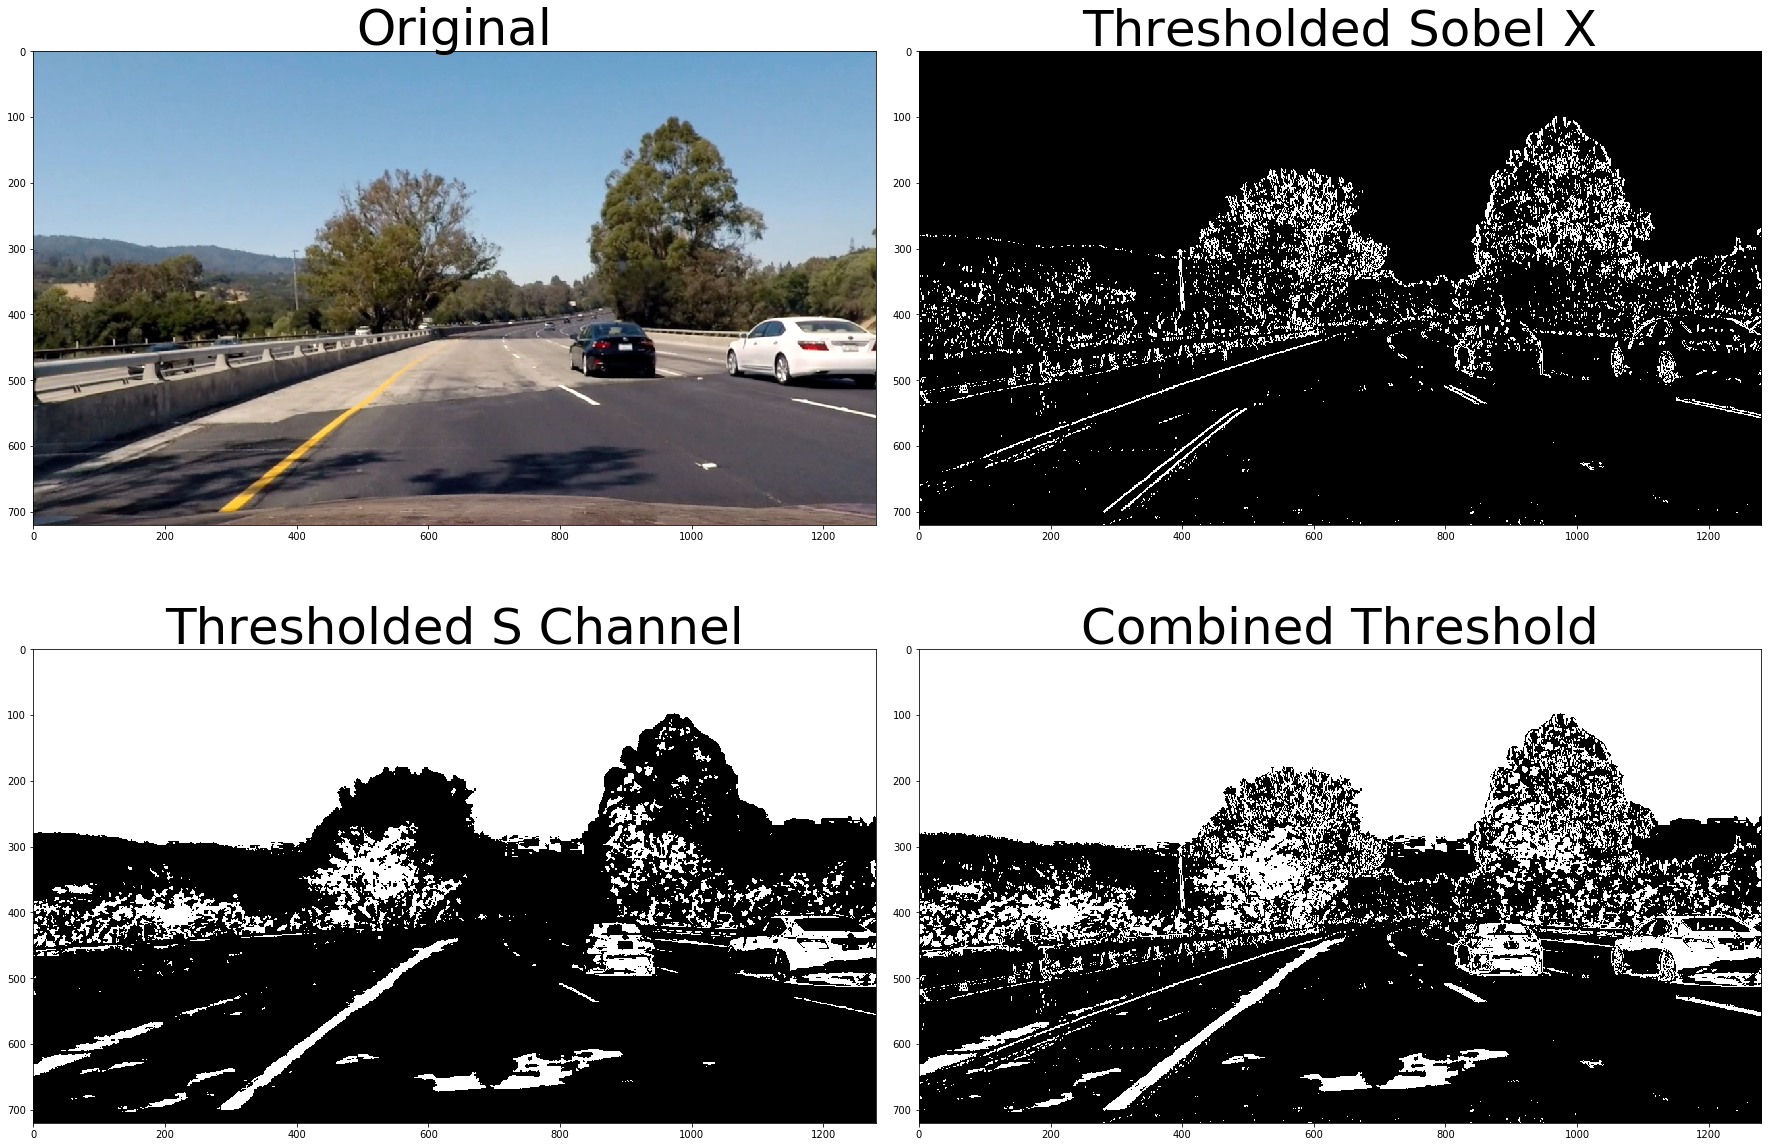

In [33]:
# Read image
image = mpimg.imread(test_images_paths[5]) # Choose image with light variation
image = cv2.undistort(image, mtx, dist, None, mtx)

# Thresholded Binary Image
bin_sobelx    = applyThresh(sobel_X(image), thresh=(20,100))
bin_s_channel = applyThresh(S_channel(image), thresh=(90,255))
bin_image     = binary_pipeline(image)

# Display
f, ax = plt.subplots(2, 2, figsize=(24, 18))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
image_names  =[image         , bin_sobelx,
               bin_s_channel , bin_image  ]
image_labels =['Original','Thresholded Sobel X','Thresholded S Channel','Combined Threshold']
ax = ax.flatten()
for i in range(len(image_names)):
    ax[i].imshow(image_names[i], cmap='gray')
    ax[i].set_title(image_labels[i], fontsize=50)

## Locate Lane Lines 

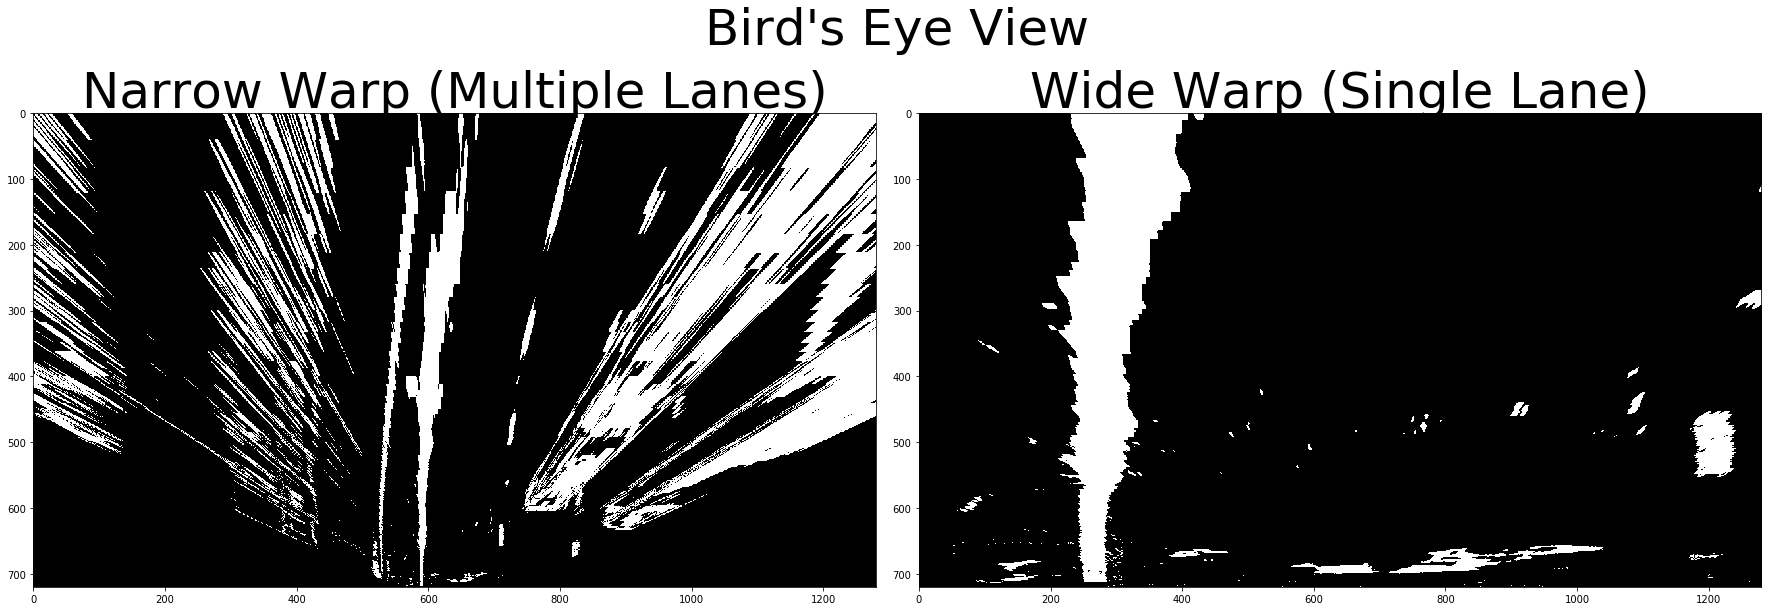

In [35]:
# Warp Binary Image
bin_warped_wide   = cv2.warpPerspective(bin_image, M_wide, (width,height))
bin_warped_narrow = cv2.warpPerspective(bin_image, M_narrow, (width,height))

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
plt.suptitle("Bird's Eye View", fontsize=50)
ax1.set_title('Narrow Warp (Multiple Lanes)', fontsize=50)
ax1.imshow(bin_warped_narrow, cmap='gray')
ax2.set_title('Wide Warp (Single Lane)', fontsize=50)
ax2.imshow(bin_warped_wide, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    h,w = img.shape
    bottom_half = img[int(h/2):h,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

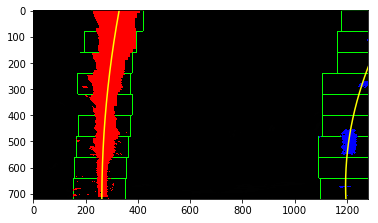

In [37]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin if leftx_current-margin>0 else 0 
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin 
        win_xright_high = rightx_current+margin if rightx_current+margin<binary_warped.shape[1] else binary_warped.shape[1]
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # good_left_inds = np.where((nonzeroy > win_y_low) & (nonzeroy < win_y_high) &
        #                  (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high))[0]
        # good_right_inds = np.where((nonzeroy > win_y_low) & (nonzeroy < win_y_high) &
        #                  (nonzerox > win_xright_low) & (nonzerox < win_xright_high))[0]
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds > minpix): leftx_current = np.mean(nonzerox[good_left_inds], dtype=np.int32)
        if len(good_right_inds > minpix): rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int32)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(bin_warped_wide)

plt.imshow(out_img)

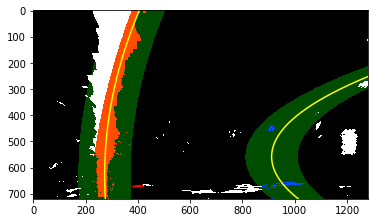

In [38]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox >= (np.polyval(left_fit,nonzeroy)-margin)) &  (nonzerox <= (np.polyval(left_fit,nonzeroy)+margin))).nonzero()[0]
    right_lane_inds = ((nonzerox >= (np.polyval(right_fit,nonzeroy)-margin)) &  (nonzerox <= (np.polyval(right_fit,nonzeroy)+margin))).nonzero()[0]
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))]) # you flip to keep contour when cv2.fillPoly
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(bin_warped_wide)

# View your output
plt.imshow(result)

## Lane Detector Pipeline
Makes use of helper functions to return image with lanes detected.

In [ ]:
https://www.mrt.kit.edu/download/Multi_Lane_Detection_and_Ego_Lane_Estimation(1).pdf

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(corners.shape, corners[0:3] ,corners[0][0])
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code
             #corners have (x,y) coordinate where y is inverted
        src = np.float32([corners[0][0],corners[7][0],corners[40][0],corners[47][0]])
        # # b2) Make sure corner points chosen look ok
        # plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        # for i, cornerPt in enumerate(src):
        #     x,y = cornerPt
        #     print(x,y)
        #     plt.plot(x, y ,'.')
        #     y_text = y-5 if y-5<0 else y+5 
        #     plt.text(x, y_text, str(i))
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[100,100],[1200,100],[100,850],[1200,850]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        h , w = undist.shape[0:2]
        warped = cv2.warpPerspective(undist, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
